In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

Splitting the raw TXT file.

In [ ]:
#DO NOT RUN IF YOU DO NOT WANT TO GENERATE NEW DATA Loadinf of the main EP dataset
#data_path = './MindBigData-EP-v1.0/EP1.01.txt'
#split_main_data(data_path=data_path, output_folder='./MindBigData-EP-v1.0')

Load the files, get the points and the list of labels

In [2]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=500) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


100%|██████████| 500/500 [00:00<00:00, 552.48it/s]


In [3]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 498
Num labels EPOC: 10
Labels EPOC: ['4', '7', '3', '8', '5', '1', '2', '9', '0', '6']
------------------------------------
Data shape EPOC (256, 14)


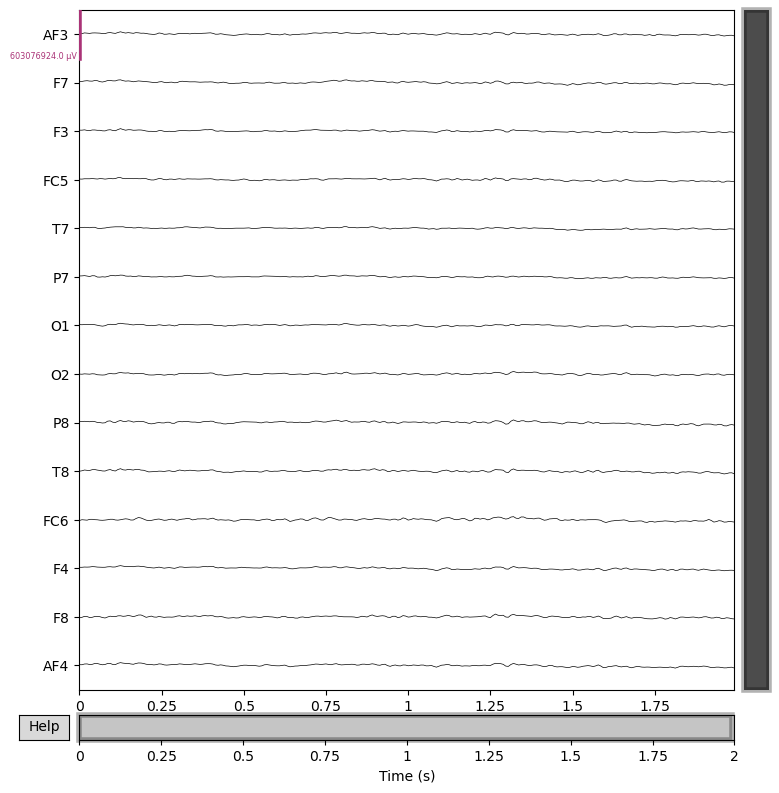

In [4]:
all_points[0].mne_object.plot(scalings = 'auto');

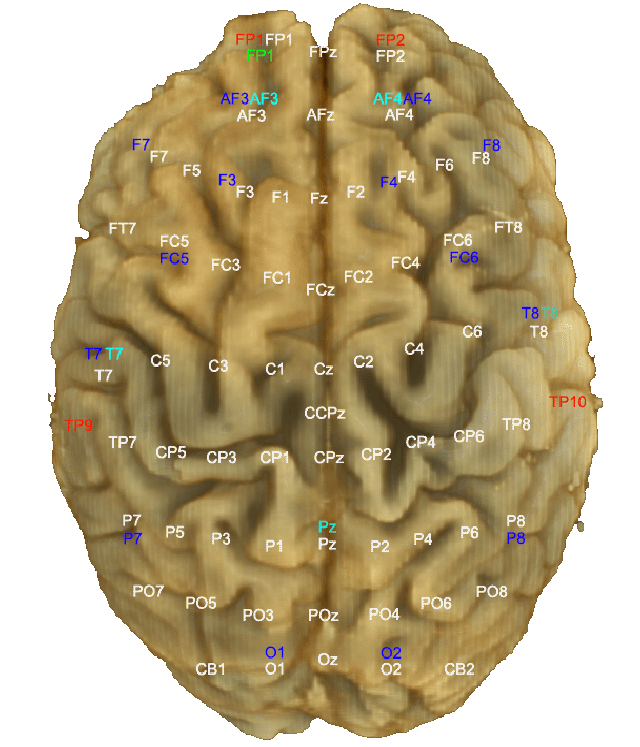

Epoc channels:---"AF3","AF4","T7","T8","P7", "F7", "F3", "FC5", "O1", "O2", "P8",  "FC6", "F4", "F8",

One paper states that best results came from 'T7', 'P7', 'P8', 'T8'

In [5]:
"""
We will loop through every data point and call the cleaning methods.
This filters the frequencies to be only between the ranges. We want 3 - 30 because this is where relevant alpha theta, beta bands lie.
MNE says to multiply the lowpass by 1/3.
"""
print("Cleaning epoc....")
for point in tqdm(all_points):
    point.full_clean(channels = ["AF3","AF4","T7","T8"], l_freq = 3, h_freq = 30)


Cleaning epoc....


100%|██████████| 498/498 [00:01<00:00, 259.33it/s]


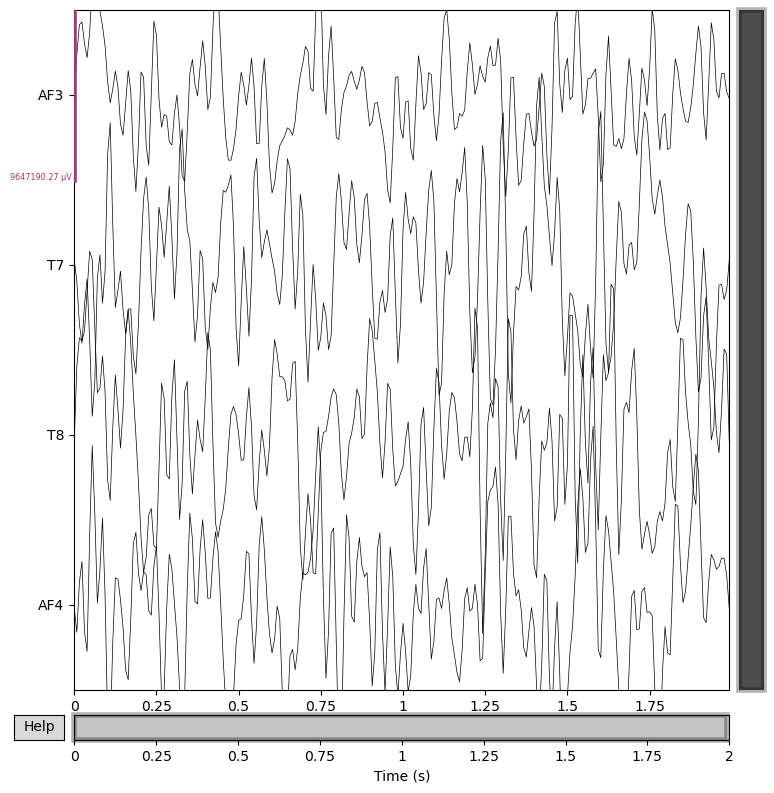

In [6]:
all_points[0].mne_object.plot(scalings='auto');

Code for normalization. Should fit train, and apply to all.

In [11]:
from EegHelper.EegAugmentation import NormalizationHelper

helper = NormalizationHelper(all_points)           #Provide the data which you want to fit with
scaler = helper.get_standard_scaler()              #Get the fit scaler
all_points = NormalizationHelper.fit_points(scaler=scaler,data_points=all_points) #Fit points after providing scaler